In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpyro
numpyro.set_host_device_count(4)

import numpy as np
from jax import numpy as jnp
from jax import random
from tqdm import trange
from numpyro import plate, sample, factor, deterministic
from numpyro.distributions import Normal, Uniform, TruncatedNormal
from numpyro.infer import MCMC, NUTS, init_to_median

import matplotlib.pyplot as plt
import scienceplots

from scipy.stats import norm
import candel

SPEED_OF_LIGHT = candel.SPEED_OF_LIGHT

In [2]:
def r2mu(r):
    return 5 * jnp.log10(r) + 25

def mu2r(mu):
    return 10**((mu - 25) / 5)

def r2czcosmo(r, H0=70):
    return r * H0

48


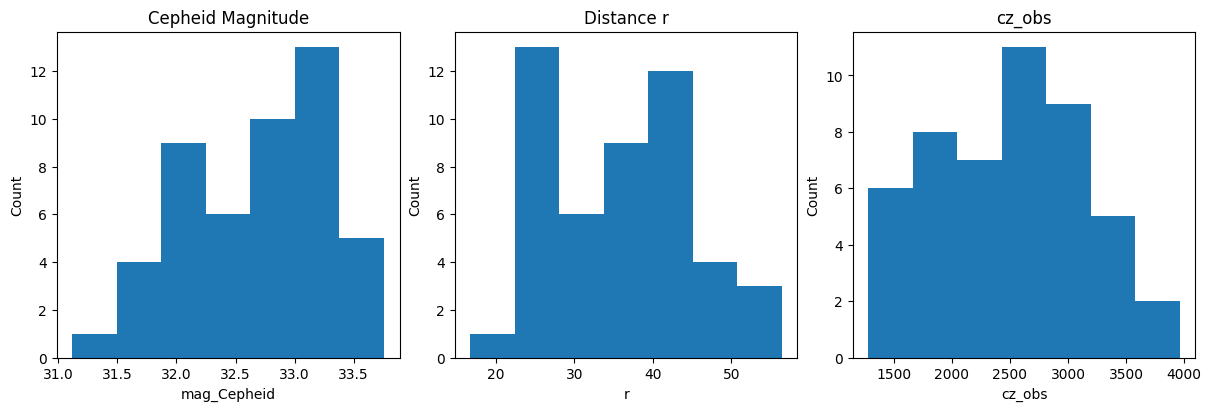

In [83]:
npoints = 500

Rmax = 100
M = -19.25
sigma_v = 250
e_mag = 0.25
H0 = 70
mag_lim = 14.
cz_lim = None


def generate_mock(seed, mag_lim=None, cz_lim=None):
    np.random.seed(seed)
    r = Rmax * np.random.uniform(0, 1, npoints)**(1/3)
    mu = r2mu(r)
    mag = mu + M + np.random.normal(0, e_mag, size=mu.shape)
    cz = r2czcosmo(r, H0=H0) + np.random.normal(0, sigma_v, size=mu.shape)

    mask = np.ones_like(mag, dtype=bool)
    if mag_lim is not None:
        mask &= mag < mag_lim
    if cz_lim is not None:
        mask &= cz < cz_lim

    return mag[mask], cz[mask], r[mask]


mag, cz, r = generate_mock(0, mag_lim=mag_lim, cz_lim=cz_lim)
print(len(mag))
mu = r2mu(r)


fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

axes[0].hist(mu, bins="auto")
axes[0].set_title('Cepheid Magnitude')
axes[0].set_xlabel('mag_Cepheid')
axes[0].set_ylabel('Count')

axes[1].hist(r, bins="auto")
axes[1].set_title('Distance r')
axes[1].set_xlabel('r')
axes[1].set_ylabel('Count')

axes[2].hist(cz, bins="auto")
axes[2].set_title('cz_obs')
axes[2].set_xlabel('cz_obs')
axes[2].set_ylabel('Count')

plt.show()

In [113]:
from jax.scipy.stats import norm as norm_jax
from interpax import Interpolator1D
from candel.model import ln_simpson


class FluxSelectionModel:

    def __init__(self, mag_lim, e_mag, Rmax_survey, M_grid=(-22, -16), Ngrid_interp=1000, Ngrid_selection=2500):
        self.mag_lim = mag_lim
        self.e_mag = e_mag
        self.Rmax_survey = Rmax_survey
        self.Ngrid_selection = Ngrid_selection

        self.M_grid = M_grid

        # Create M evaluation grid for interpolation
        # if mag_lim is not None:
        #     M_vals = jnp.linspace(M_grid[0], M_grid[1], Ngrid_interp)
        #     log_S_vals = jnp.array([self.log_S_M(Mi) for Mi in M_vals])

        #     self.f_log_S_M= Interpolator1D(M_vals, log_S_vals, extrap=False, method="cubic")

    def log_S_M(self, M, mag_lim):
        r = jnp.linspace(1e-6, self.Rmax_survey, self.Ngrid_selection)
        mu_r = 5 * jnp.log10(r) + 25
        log_cdf = norm_jax.logcdf((mag_lim - (mu_r + M)) / self.e_mag)
        log_integral = ln_simpson(2 * jnp.log(r) + log_cdf, x=r)
        return jnp.log(3) - 3 * jnp.log(self.Rmax_survey) + log_integral

    def __call__(self, mag_obs, cz_obs):
        N = len(mag_obs)

        M = sample('M', TruncatedNormal(
            -19.25, 0.5, low=self.M_grid[0], high=self.M_grid[1]))
        # M_SN = sample('M_SN', Normal(-19.25, 0.2))
        # M_SN = -19.25
        # M = -19.25
        # H0 = sample('H0', Normal(10, 100))
        H0 = 70
        # mag_lim = sample('mag_lim', Uniform(self.mag_lim - 3, self.mag_lim + 3))
        mag_lim = self.mag_lim
        factor("global_norm", -N * self.log_S_M(M, mag_lim))

        with plate('galaxies_lp', N):
            r = sample('r', Uniform(0, self.Rmax_survey))
            factor("log_r", 2 * jnp.log(r))

            mu_r = 5 * jnp.log10(r) + 25
            m_mean = mu_r + M
            cz = r2czcosmo(r, H0=H0)

        with plate('galaxies_ll', N):
            sample('mag_obs', Normal(m_mean, self.e_mag), obs=mag_obs)
            sample('cz_obs', Normal(cz, sigma_v), obs=cz_obs)


class RedshiftSelectionModel:

    def __init__(self, cz_lim, e_mag, Rmax_survey, H0_grid=(50, 100), Ngrid_interp=1000, Ngrid_selection=2500):
        self.mag_lim = mag_lim
        self.e_mag = e_mag
        self.Rmax_survey = Rmax_survey
        self.Ngrid_selection = Ngrid_selection
        self.sigma_v = 250
        self.cz_lim = cz_lim

        self.H0_grid = H0_grid

        # Create M evaluation grid for interpolation
        if cz_lim is not None:
            H0_vals = jnp.linspace(self.H0_grid[0], self.H0_grid[1], Ngrid_interp)
            log_S_vals = jnp.array([self.log_S_H0(H0i) for H0i in H0_vals])

            self.f_log_S_H0= Interpolator1D(H0_vals, log_S_vals, extrap=False, method="cubic")
            print("initialized!")

    def log_S_H0(self, H0):
        r = jnp.linspace(1e-6, self.Rmax_survey, self.Ngrid_selection)
        
        cz_r = r2czcosmo(r, H0=H0)
        log_cdf = norm_jax.logcdf((self.cz_lim - cz_r) / self.sigma_v)
        log_integral = ln_simpson(2 * jnp.log(r) + log_cdf, x=r)
        return jnp.log(3) - 3 * jnp.log(self.Rmax_survey) + log_integral

    def __call__(self, mag_obs, cz_obs):
        N = len(mag_obs)

        # M = sample('M', TruncatedNormal(
        #     -19.25, 0.5, low=self.M_grid[0], high=self.M_grid[1]))
        M = -19.25
        H0 = sample('H0', Uniform(self.H0_grid[0], self.H0_grid[1]))
        factor("global_norm", -N * self.f_log_S_H0(H0))

        with plate('galaxies_lp', N):
            r = sample('r', Uniform(0, self.Rmax_survey))
            factor("log_r", 2 * jnp.log(r))

            mu_r = 5 * jnp.log10(r) + 25
            m_mean = mu_r + M
            cz = r2czcosmo(r, H0=H0)

        with plate('galaxies_ll', N):
            sample('mag_obs', Normal(m_mean, self.e_mag), obs=mag_obs)
            sample('cz_obs', Normal(cz, sigma_v), obs=cz_obs)


class JointSelectionModel:

    def __init__(self, cz_lim, mag_lim, e_mag, Rmax_survey, H0_grid=(50, 100), Ngrid_interp=1000, Ngrid_selection=2500):
        self.mag_lim = mag_lim
        self.e_mag = e_mag
        self.Rmax_survey = Rmax_survey
        self.Ngrid_selection = Ngrid_selection
        self.sigma_v = 250
        self.cz_lim = cz_lim

        self.H0_grid = H0_grid

    def log_S(self, M, H0):
        r = jnp.linspace(1e-6, self.Rmax_survey, self.Ngrid_selection)

        mag = r2mu(r) + M
        cz = r2czcosmo(r, H0=H0)

        log_cdf = norm_jax.logcdf((mag_lim - mag) / self.e_mag)
        log_cdf += norm_jax.logcdf((self.cz_lim - cz) / self.sigma_v)

        log_integral = ln_simpson(2 * jnp.log(r) + log_cdf, x=r)
        return jnp.log(3) - 3 * jnp.log(self.Rmax_survey) + log_integral

    def __call__(self, mag_obs, cz_obs):
        N = len(mag_obs)

        # M = sample('M', Normal(-19.25, 0.5))
        M = -19.25
        H0 = sample('H0', Uniform(self.H0_grid[0], self.H0_grid[1]))
        factor("global_norm", -N * self.log_S(M, H0))

        with plate('galaxies_lp', N):
            r = sample('r', Uniform(0, self.Rmax_survey))
            factor("log_r", 2 * jnp.log(r))

            mu_r = 5 * jnp.log10(r) + 25
            m_mean = mu_r + M
            cz = r2czcosmo(r, H0=H0)

        with plate('galaxies_ll', N):
            sample('mag_obs', Normal(m_mean, self.e_mag), obs=mag_obs)
            sample('cz_obs', Normal(cz, sigma_v), obs=cz_obs)

In [114]:
num_warmup = 100
num_steps = 500
model = FluxSelectionModel(mag_lim=mag_lim, e_mag=e_mag, Rmax_survey=Rmax)
# model = RedshiftSelectionModel(cz_lim=cz_lim, e_mag=e_mag, Rmax_survey=Rmax)
# model = JointSelectionModel(cz_lim=cz_lim, mag_lim=mag_lim, e_mag=e_mag, Rmax_survey=Rmax)

nrepeat = 1
progress_bar = nrepeat == 1

bias = []


for i in trange(nrepeat, desc="Running MCMC", disable=progress_bar):
    mag, cz, r = generate_mock(500 + i, mag_lim=mag_lim, cz_lim=cz_lim)

    kernel = NUTS(model, init_strategy=init_to_median(num_samples=2500))
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_steps, num_chains=4, progress_bar=progress_bar)
    mcmc.run(
        random.PRNGKey(i),
        mag_obs=jnp.asarray(mag),
        cz_obs=jnp.asarray(cz),
        )

    samples = mcmc.get_samples()
    if progress_bar:
        mcmc.print_summary()
    
    param = "M"
    if param == "M":
        x0 = M
    elif param == "H0":
        x0 = H0
    else:
        raise ValueError("Unknown parameter: {}".format(param))

    bias.append((jnp.mean(samples[param]) - x0) / jnp.std(samples[param]))

bias = jnp.asarray(bias)

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         M    -19.31      0.05    -19.31    -19.40    -19.24   1736.13      1.00
      r[0]     43.99      2.82     43.97     39.47     48.49   2826.04      1.00
      r[1]     46.70      2.98     46.73     41.79     51.63   3357.38      1.00
      r[2]     36.34      2.71     36.24     32.42     41.51   3019.53      1.00
      r[3]     46.40      2.80     46.31     41.94     51.07   3473.05      1.00
      r[4]     32.88      2.57     32.86     28.38     36.75   4275.63      1.00
      r[5]     35.89      2.67     35.83     31.48     40.12   2914.37      1.00
      r[6]     38.50      2.84     38.44     33.65     42.99   3269.10      1.00
      r[7]     35.73      2.87     35.61     31.22     40.35   3541.91      1.00
      r[8]     26.61      2.44     26.57     22.73     30.67   3720.82      1.00
      r[9]     47.38      2.93     47.24     42.95     52.44   4166.63      1.00
     r[10]     45.13      2

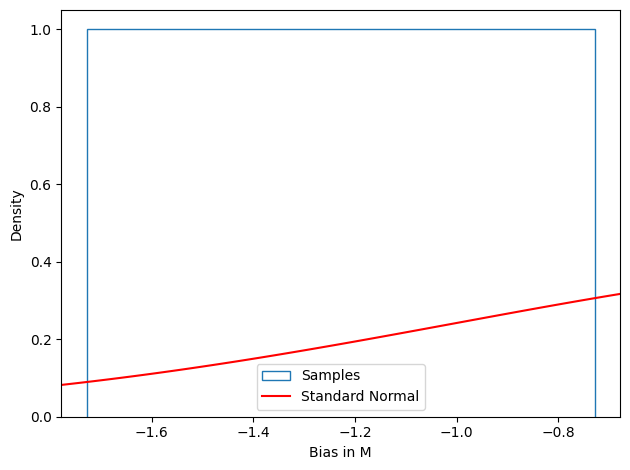

In [115]:
plt.figure()
plt.hist(bias, bins="auto", density=True, label="Samples", histtype="step")
xlim = plt.xlim()
xrange = np.linspace(*xlim, 100)
plt.plot(xrange, norm.pdf(xrange), label="Standard Normal", color='red')
plt.xlim(*xlim)

plt.xlabel("Bias in M")
plt.ylabel("Density")
plt.legend()


plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/M_bias.png", dpi=300)
plt.show()

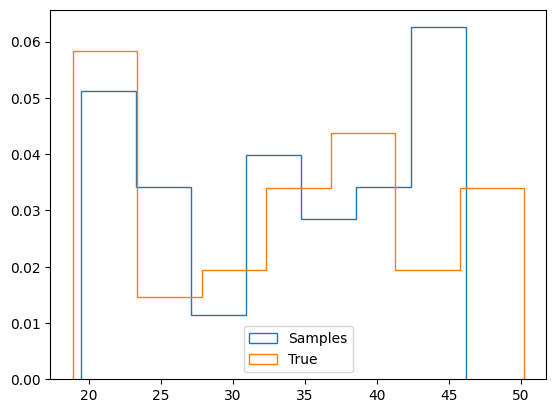

In [76]:
plt.figure()
plt.hist(np.mean(samples["r"], axis=0), bins="auto", density=True, label="Samples", histtype="step")
plt.hist(r, bins="auto", density=True, label="True", histtype="step")

plt.legend()


plt.show()


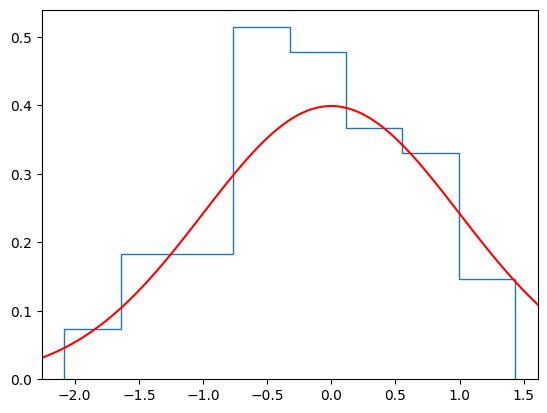

In [48]:
dx = (np.mean(samples["r"], axis=0) - r) / np.std(samples["r"], axis=0)
plt.figure()
plt.hist(dx, bins="auto", density=True, label="Samples", histtype="step")

xlim = plt.xlim()
xrange = np.linspace(*xlim, 100)
plt.plot(xrange, norm.pdf(xrange), label="Standard Normal", color='red')
plt.xlim(*xlim)

plt.show()

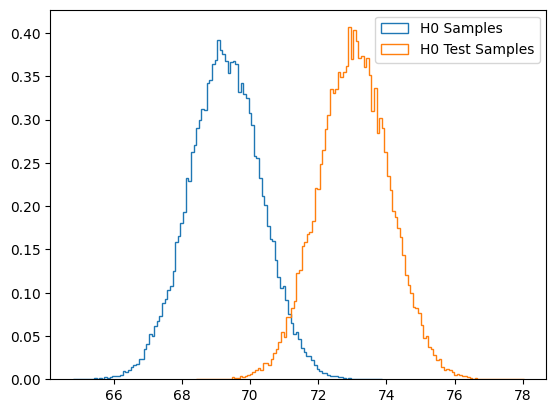

p-value 0.009, corresponding to 2.5988 sigmas


In [8]:
import posterior_agreement

# H0 = norm(68.55, 0.93).rvs(50_000)
H0 = norm(69.26, 1.06).rvs(50_000)
H0_test = norm(73.04, 1.04).rvs(50000)

plt.figure()
plt.hist(H0, bins="auto", density=True, label="H0 Samples", histtype="step")
plt.hist(H0_test, bins="auto", density=True, label="H0 Test Samples", histtype="step")
plt.legend()
plt.show()


chains = (H0, H0_test)
agreement_1d = posterior_agreement.compute_agreement(chains)
# 
print("p-value %.3f, corresponding to %.4f sigmas"%(agreement_1d.PTE, agreement_1d.sigma))